# Making Hunger Score Predictions
### Approach:
* Models: Lasso, Random Forest Regressor (RF), Support Vector Regression (SVR)
* Perfomr a grid search for 1-month and 3-month predictions of all models
* Used Lasso (and RF) to measure feature importance  

### Results:
* Lasso: An empty model — ie all coefficients converged to zero.
* RF: Battle count was the only feature used to only slightly improve upon a baseline prediction of the sample average hunger score.
* SVR: Performed far worse than the baseline prediction by sample average. Possibly due to skewed data.

## 1 Load and Clean Data
* load and drop redundant columns
* NaNs of event data should be converted to 0s
* event data convert to log scale to reduce skew
* make Admin1 names unique
* look at statistics for features and the hunger score

In [1]:
import pandas as pd
import pipeline
import importlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [3]:
import warnings
warnings.filterwarnings(action='once')

In [13]:
# for reloading the pipeline if neccesary...
importlib.reload(pipeline)

<module 'pipeline' from '/Users/matthewmauer/ML/project/pipeline.py'>

In [5]:
data = pipeline.read('create_targets/total_data_with_targets.csv')
data.sample(5)

There are 14068 rows and 24 columns in the data set.


,ADMIN0,ADMIN1,month,year,CS,tmin_mm,tmax_mm,tavg_mm,prcp_mm,battle_cnt,...,battle_fatal,protest_fatal,riot_fatal,explosion_fatal,violence_on_civs_fatal,Retail,pop,CS_in_1_month,CS_in_2_months,CS_in_3_months
10506,Sudan,Sinnar,7.0,2011.0,1.5,238.325000,377.571429,295.750000,7.500000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1505000.0,NaN,NaN,2.0
4906,Kenya,Trans Nzoia,12.0,2019.0,NaN,131.629630,253.142857,184.838710,53.764706,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,818757.0,NaN,NaN,NaN
5346,Kenya,West Pokot,3.0,2015.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,512690.0,1.5,NaN,NaN
11412,Tanzania,Dar es Salaam,4.0,2013.0,NaN,233.391304,324.041667,268.689655,93.950000,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3105,Kenya,Mandera,9.0,2016.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,4.0,0.0,NaN,1025756.0,2.0,NaN,NaN


In [14]:
data = pipeline.clean_events(data)

In [26]:
data = pipeline.unique_regions(data)

### View Statistics

In [17]:
features = ['tmin_mm', 'tmax_mm', 'tavg_mm', 'prcp_mm',
       'battle_cnt', 'protest_cnt', 'riot_cnt', 'explosion_cnt',
       'violence_on_civs_cnt', 'battle_fatal', 'protest_fatal',
       'riot_fatal', 'explosion_fatal', 'violence_on_civs_fatal',
       'Retail', 'pop']

data[features].describe()

,tmin_mm,tmax_mm,tavg_mm,prcp_mm,battle_cnt,protest_cnt,riot_cnt,explosion_cnt,violence_on_civs_cnt,battle_fatal,protest_fatal,riot_fatal,explosion_fatal,violence_on_civs_fatal,Retail,pop
count,3308.000000,3051.000000,3786.000000,2355.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,4661.000000,7.895000e+03
mean,194.006999,324.045806,259.036633,75.495813,0.403487,0.217546,0.127565,0.164981,0.382583,0.556682,0.015135,0.048254,0.158233,0.378231,0.642517,2.708599e+06
std,48.576061,50.874524,47.393798,119.916669,0.747403,0.476890,0.347086,0.502241,0.654209,1.171873,0.175835,0.263668,0.607038,0.821119,1.419446,5.611861e+06
min,54.950000,200.000000,143.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.445507,1.015390e+05
25%,153.174020,287.136646,226.445968,14.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.201266,7.439460e+05
50%,197.124060,317.000000,261.696154,43.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.474682,1.098584e+06
75%,234.937500,360.302778,291.386966,85.085965,0.693147,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,1.312802,1.994000e+06
max,329.100000,464.833333,389.000000,2009.000000,4.043051,5.513429,3.401197,3.850148,3.931826,6.895683,5.241747,5.323010,6.437752,8.074960,7.108684,3.748900e+07


In [18]:
data.CS_in_1_month.describe()

count    2705.000000
mean        1.916313
std         0.620740
min         1.000000
25%         1.500000
50%         2.000000
75%         2.333333
max         4.500000
Name: CS_in_1_month, dtype: float64

## 2.1 LASSO Regression for 3-month Predictions
* perform a small grid search tuning the alpha from the loss function
* use group k-fold cross validation to prevent data leakage
* discover feature importance

In [19]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [20]:
features = ['tmin_mm', 'tmax_mm', 'tavg_mm', 'prcp_mm',
       'battle_cnt', 'protest_cnt', 'riot_cnt', 'explosion_cnt',
       'violence_on_civs_cnt', 'battle_fatal', 'protest_fatal',
       'riot_fatal', 'explosion_fatal', 'violence_on_civs_fatal',
       'Retail', 'pop']

Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_3_months',
                                                       grouping='ADMIN1')

In [21]:
lasso_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('lasso', Lasso())
])

params = {
    'lasso__alpha': (0.01, 0.1, 1, 10, 100) 
} 

scores = {
          'mse': make_scorer(mean_squared_error),
          'mae': make_scorer(mean_absolute_error),
         }

gcv = GroupKFold()

lasso_grid_model = GridSearchCV(estimator=lasso_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

lasso_grid_results = lasso_grid_model.fit(Xtrain, Ytrain, groups=groups)

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [22]:
lasso_scores = pd.DataFrame(lasso_grid_results.cv_results_)
results = lasso_scores[['param_lasso__alpha', 'mean_test_mse', 'mean_test_mae']]
results

,param_lasso__alpha,mean_test_mse,mean_test_mae
0,0.01,0.361619,0.479757
1,0.1,0.364443,0.482209
2,1,0.393555,0.506596
3,10,0.393555,0.506596
4,100,0.393555,0.506596


In [23]:
best_lasso = lasso_grid_results.best_estimator_
pipeline.model_eval(best_lasso, Xtest, Ytest)


        MSE: 0.3192245273316907
        MAE: 0.48551725449232375
        For a target variable with Variance: 0.30427033252513075
        


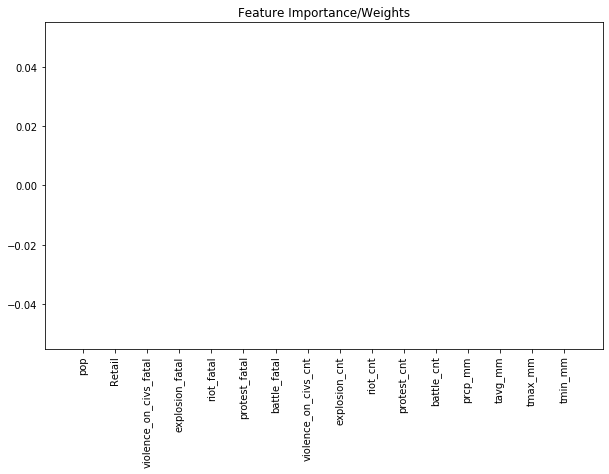

In [24]:
pipeline.feature_importance(best_lasso['lasso'],
                            labels=Xtrain.columns.values)

### Results
Even after normalizing, we have essentially an empty model.

## 2.2 LASSO Regression for 1-month Predictions
Repeat the above process.

In [25]:
Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_1_month',
                                                       grouping='ADMIN1')

lasso2_grid_model = GridSearchCV(estimator=lasso_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

lasso2_grid_results = lasso2_grid_model.fit(Xtrain, Ytrain, groups=groups)

lasso2_scores = pd.DataFrame(lasso2_grid_results.cv_results_)
results2 = lasso2_scores[['param_lasso__alpha', 'mean_test_mse', 'mean_test_mae']]
results2

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


,param_lasso__alpha,mean_test_mse,mean_test_mae
0,0.01,0.375049,0.479874
1,0.1,0.378418,0.482580
2,1,0.402052,0.497834
3,10,0.402052,0.497834
4,100,0.402052,0.497834


In [26]:
best_lasso2 = lasso2_grid_results.best_estimator_
pipeline.model_eval(best_lasso2, Xtest, Ytest)


        MSE: 0.3161452279542899
        MAE: 0.4683750070010606
        For a target variable with Variance: 0.316082120194306
        


## Results
Again, we have an empty model.

## 3.1 Random Forest Regressor for 3-month Predictions

In [27]:
Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_3_months',
                                                       grouping='ADMIN1')

forest_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('forest', RandomForestRegressor(random_state=30254))
])

params = {
    'forest__max_depth': (1, 3, 10), 
    'forest__n_estimators': (5, 25, 100)
}

scores = {
          'mse': make_scorer(mean_squared_error),
          'mae': make_scorer(mean_absolute_error),
         }

gcv = GroupKFold()

forest_grid_model = GridSearchCV(estimator=forest_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

forest_grid_results = forest_grid_model.fit(Xtrain, Ytrain, groups=groups)

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [28]:
forest_scores = pd.DataFrame(forest_grid_results.cv_results_)
results = forest_scores[['param_forest__max_depth', 
                         'param_forest__n_estimators',
                        'mean_test_mse', 'mean_test_mae']]
results

,param_forest__max_depth,param_forest__n_estimators,mean_test_mse,mean_test_mae
0,1,5,0.350897,0.471671
1,1,25,0.351300,0.471903
2,1,100,0.351335,0.471868
3,3,5,0.331966,0.446466
4,3,25,0.323485,0.441901
5,3,100,0.322553,0.441185
6,10,5,0.339588,0.452650
7,10,25,0.325835,0.440072
8,10,100,0.321739,0.439196


In [29]:
best_forest = forest_grid_results.best_estimator_
pipeline.model_eval(best_forest, Xtest, Ytest)


        MSE: 0.3003485081626862
        MAE: 0.46859682681106646
        For a target variable with Variance: 0.30427033252513075
        


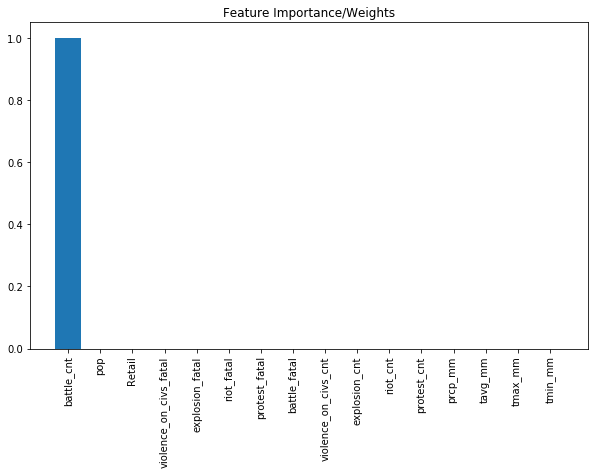

In [30]:
pipeline.feature_importance(best_forest['forest'],
                            labels=Xtrain.columns.values,
                            type='tree')

## 3.2 Random Forest Regressor for 1-month Predictions

In [31]:
Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_1_month',
                                                       grouping='ADMIN1')

forest2_grid_results = forest_grid_model.fit(Xtrain, Ytrain, groups=groups)

pd.DataFrame(forest2_grid_results.cv_results_)[['param_forest__max_depth', 
                                               'param_forest__n_estimators',
                                               'mean_test_mse', 'mean_test_mae']]

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


,param_forest__max_depth,param_forest__n_estimators,mean_test_mse,mean_test_mae
0,1,5,0.381780,0.488786
1,1,25,0.378143,0.487196
2,1,100,0.376026,0.486376
3,3,5,0.344929,0.458274
4,3,25,0.343332,0.457727
5,3,100,0.341514,0.456631
6,10,5,0.341240,0.444434
7,10,25,0.323991,0.436510
8,10,100,0.318035,0.433125


In [32]:
best_forest2 = forest2_grid_results.best_estimator_
pipeline.model_eval(best_forest2, Xtest, Ytest)


        MSE: 0.2834548987796996
        MAE: 0.45057976925645293
        For a target variable with Variance: 0.316082120194306
        


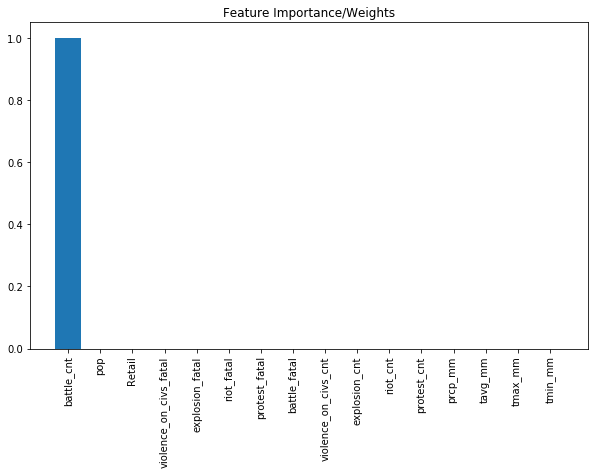

In [33]:
pipeline.feature_importance(best_forest2['forest'],
                            labels=Xtrain.columns.values,
                            type='tree')

## 4 Support Vector Regressor for 3-month Predictions

In [34]:
from sklearn.svm import SVR

In [35]:
Xtrain, Xtest, Ytrain, Ytest, groups = pipeline.five_way_split(data,
                                                       year=2018,
                                                       features=features,
                                                       target='CS_in_1_month',
                                                       grouping='ADMIN1')

svr_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('svr', SVR())
])

params = {
    'svr__kernel': ('poly', 'rbf'),
    'svr__C': (0.1, 1, 10),
    'svr__degree': (2,)
    
} 

scores = {
          'mse': make_scorer(mean_squared_error),
          'mae': make_scorer(mean_absolute_error),
         }

svr_grid_model = GridSearchCV(estimator=svr_pipe, 
                          param_grid=params, 
                          cv=gcv,
                          return_train_score=True,
                          scoring=scores,
                          refit='mse',
                          iid=True)

svr_grid_results = svr_grid_model.fit(Xtrain, Ytrain, groups=groups)

/Users/matthewmauer/anaconda3/envs/ml30254/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [36]:
pd.DataFrame(svr_grid_results.cv_results_)[['param_svr__kernel', 'param_svr__C',
                                               'mean_test_mse', 'mean_test_mae']]

,param_svr__kernel,param_svr__C,mean_test_mse,mean_test_mae
0,poly,0.1,0.360264,0.459378
1,rbf,0.1,0.324309,0.432413
2,poly,1,0.425730,0.480298
3,rbf,1,0.335879,0.443459
4,poly,10,0.929195,0.532469
5,rbf,10,0.388652,0.480374


In [37]:
best_svr = svr_grid_results.best_estimator_
pipeline.model_eval(best_svr, Xtest, Ytest)


        MSE: 0.3994730110675817
        MAE: 0.48965041976927054
        For a target variable with Variance: 0.316082120194306
        
